In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def mse_from_e(residual):
	"""
	ACT 1: Compute the mean squared error from a residual array.
	
	Parameters:
	-----------
	residual : np.array (m x 1)
		The result of y_hat - y

	Returns:
	--------
	mse : float
		The mean squared error
	"""
	return np.mean(np.square(residual))


def mean_squared_error(X, y, w):
	"""
	ACT 2: Compute the mean squared error.
	
	Parameters:
	-----------
	X : np.array (m x n)
		The dataset matrix 
	y : np.array (m x 1)
		The labels vector of X
	w : np.array (n x 1)
		The weight vector of X

	Returns:
	--------
	mse: float
		The mean squared error
	"""
	y_hat = np.dot(X, w)
	return mse_from_e(y_hat - y)


def test_mse_from_e():
    a = np.zeros((5, 1))
    b = np.ones((5, 1))    
    assert mse_from_e(a-b) == 1.0
    assert mse_from_e(a-a) == 0.0
    assert mse_from_e(b-b) == 0.0

    
def test_mean_squared_error():
    X = np.ones((3, 3))
    y = np.ones((3, 1))
    w = np.ones((3, 1))
    assert mean_squared_error(X, y, w) == 4.0
    assert mean_squared_error(X, y * 2, w) == 1.0
    

test_mse_from_e()
test_mean_squared_error()

In [3]:
def genu(d, m):
	"""
	Generate a sawtooth weight vector
	"""
	u = np.arange(d) * (2 * (np.arange(d) % 2) - 1)
	u = m * u / np.sqrt(np.dot(u, u))
	return u


def genx(n, d):
	"""
	Generate random data
	"""
	X = np.random.randint(0, 2, (n, d))
	X[:,int(d/2)] = 1
	return X


def gent(X, u, noise):
	"""
	Generate targets and add noise
	"""
	n = X.shape[0]
	y = np.dot(X, u).reshape(n, 1)
	y += noise * np.var(y) * np.random.randn(n, 1)
	return y


def gimme_data_regres(n, d, noise=0.1, verbose=True):
	"""
	Generate data, weights, and targets
	"""
	u = genu(d, 1.0)
	X = genx(n, d)
	y = gent(X, u, noise)
	mse_gen = mean_squared_error(X, y, u)
	if verbose:
		print('Generator Loss={0:8.5f}\n'.format(mse_gen))
	return X, u, y

In [4]:
def loss_plotter(vlist, fname):
	"""
	Plot loss as a function of epoch
	"""
	vr = vlist[0]
	vn = vlist[1]
	plt.plot(range(1, 1+len(vr)), vr,
		   range(1, 1+len(vn)), vn,
		   linewidth=2, linestyle='-', marker='o')
	plt.legend(('rep', 'nor'))
	plt.grid()
	xt = np.arange(1, 1 + max(len(vr), len(vn)))
	_ = plt.xticks(xt)
	_ = plt.xlabel('Epoch', fontsize=14)
	_ = plt.ylabel(fname, fontsize=14)
	plt.show()
	return


def loss_scatter(X, y, w, fname):
	"""
	Scatter plot of predicted vs. observed targets
	"""
	plt.scatter(y, X.dot(w), edgecolors=(0,0,0))
	plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
	plt.grid()
	plt.xlabel('$y$', fontsize=14)
	plt.ylabel('$\hat{y}$', fontsize=14)
	plt.show()

In [5]:
def sample_new_index(d, replace=1):
    """
    ACT 3 and 4: Sample new index (w/ or w/o replacement)
    
    Parameters:
    ----------
    d : int
        num of dimensions to sample
    replace: bool, options
        Flag to switch between w/ and w/o replacment.
        Defaults to True, which samples w/replacement.
    
    Returns
    -------
    ind : int
        The next index to sample, at random.
    """
    if replace:
        # ACT3
        ind = np.random.choice(d)

    else:
        if 'prm' not in sample_new_index.__dict__:
            sample_new_index.prm = np.random.permutation(d)
            sample_new_index.head = 0
        
        # ACT4
        ind = sample_new_index.prm[sample_new_index.head]
        sample_new_index.head += 1
        
        if sample_new_index.head == d:
            sample_new_index.head = 0
            del sample_new_index.prm
    return ind


def test_sample_new_index_with_replacement():
    a = np.arange(0, 10)
    d = np.random.choice(a) + 1
    index = sample_new_index(d, replace=1)
    assert index in a
    

def test_sample_new_index_without_replacement():
    d = int(10 * np.random.random() + 1)
    a = np.arange(d)
    visited = set()    
    for count in range(d):
        index = sample_new_index(d, replace=0)
        visited.add(index)
    assert len(visited) == d

for _ in range(10):
    test_sample_new_index_with_replacement()
    test_sample_new_index_without_replacement()

In [6]:
def delta_wj(e, xj, xjs):
	"""
	ACT 5: Calculate the change to w[j] w.r.t current margins z.
	
	Parameters
	----------
	e : np.array (m x 1)
		The residual result of y_hat - y
	xj : np.array 
		Column vector j of matrix X.
	xjs : float 
		Squared norm of the jth colum of X, a.k.a. ||Xj||^2.
		
	Returns
	-------
	a : float
		The value of wj_new - wj.
	"""
	a = e * xj
	return -1 * np.sum(a) / xjs


def update(wj, e, xj, xjs):
	"""
	ACT 6: Update value of wj with a, in place, and compute new residual

	Parameters
	----------
	wj : scalar
		The current wj
	e : np.array (m x 1)
		The residual result of y_hat - y
	xjs : float 
		Squared norm of the jth colum of X, a.k.a. ||Xj||^2.
		
	Returns
	-------
	wj_new : float
		The updated value of wj_new
	residual : np.array (m x 1)
		The updated residual
	"""	
	a = delta_wj(e, xj, xjs)
	wj += a
	residual = e + a * xj	
	return wj, residual


def test_delta_wj(n, d):
    xj = np.ones((n, d))
    xjs = np.linalg.norm(xj) ** 2
    e = np.random.randint(0, 2, (n, d))
    delta = delta_wj(e, xj, xjs)
    assert math.fabs(delta + np.sum(e) / xjs) < 1e-3
    return e, xj, xjs, delta


def test_update(n, d):
    wj = np.zeros((n, d))
    e, xj, xjs, delta = test_delta_wj(n, d)
    update(wj, e, xj, xjs)
    assert np.sum(wj) == np.sum(np.zeros((n, d)) + delta)


n, d = 5, 1
test_delta_wj(n, d)
test_update(n, d)

In [7]:
def initialize(X, y):
	"""
	ACT 7: Initialize all variables using the zero vector for w
	
	Parameters
	----------
	X : np.array (m x n)
		The data matrix.
	y : np.array (m x 1)
		The labels vector.
	
	Returns
	-------
	w : np.array (n x 1)
		The initial weights vector.
	xjs : np.array (n x 1)
		Squared norm of all the jth columns of X, a.k.a. ||Xj||^2.
	residual : np.array (m x 1)
		The residual result of y_hat - y
	"""
	
	m, n = X.shape
	w = np.zeros((n, 1))
	xjs = np.square(np.linalg.norm(X, axis=0))
	residual = -y
	return w, xjs, residual


def test_initialize(n, d, noise):
    X, u, y = gimme_data_regres(n, d, noise, verbose=False)
    w, wjs, residual = initialize(X, y)
    
    assert np.sum(w) == 0.0
    assert w.shape == (n, 1)
    assert np.sum(residual) == np.sum(np.dot(X, w) - y)


for n in range(10):
    for m in range(10):
        test_initialize(10, 10, 0.5)

In [8]:
def mse_check(mse_p, mse_c, eps):
	"""
	ACT 8: Check whether termination condition is met
	
	Parameters
	----------
	mse_p : float
		Previous loss, that is, at last iteration. 
	mse_c : float
		Current loss, that is, at this iteration. 
	eps : float
		Target accuracy threshold.

	Returns
	-------
	flag : bool
		True if the normalized difference in losses is
		smaller than the accuracy threshold.
		Otherwise, False.

	Notes
	-----
	Loss is defined as the mean squared error.
	Loss should not be negative.
	"""
	relative_loss = (mse_p - mse_c) / mse_c
	msg = '***Termination condition was met: {0} <= {1}***'
	
	if relative_loss <= eps:
		print(msg.format(relative_loss, eps))
		return True
	return False


def test_mse_check():
    assert mse_check(1.0, 0.5, 0.049) == False
    assert mse_check(0.0001, 0.00009, 0.00001) == True

In [9]:
def linear_regression_cd(X, y, epochs=100, eps=0.001, replace=1):
	"""
	Do linear regression using coordinate decent.
	
	Parameters
	----------
	X : np.array (m x n)
		The data matrix.
	y : np.array (m x 1)
		The labels vector.
	epochs : int, optional
		The number of iterations to be run.
		Defaults to 100.
	eps : float, optional
		The accuracy threshold.
		Defaults to 0.001.
	replace : bool, optional
		Flag to choose replacement mode.
		True for updates w/replacement.
		False for updates w/o replacement.
		Defaults to True.
	
	Returns
	-------
	w : np.array (n x 1)
		The weight vector of X after all epochs.
	mse_cd : list
		The losses over all epochs.
	"""
	w, xjs, residual = initialize(X, y)
	mse_cd = [mse_from_e(residual)]
	n, d = X.shape

	for e in range(epochs):
		for i in range(d):
			j = sample_new_index(d, replace)
			xj = X[:,j].reshape(n, 1)
			w[j], residual = update(w[j], residual, xj, xjs[j])

		mse_cd.append(mse_from_e(residual))
		print('Epoch: {0:2d}  MSE: {1:5.3f}'.format(e, mse_cd[-1]))
			
		if mse_check(mse_cd[-2], mse_cd[-1], eps):
			break

	return w, mse_cd

Generator Loss= 0.55901

Epoch:  0  MSE: 0.194
Epoch:  1  MSE: 0.130
Epoch:  2  MSE: 0.084
Epoch:  3  MSE: 0.078
Epoch:  4  MSE: 0.074
Epoch:  5  MSE: 0.063
Epoch:  6  MSE: 0.059
Epoch:  7  MSE: 0.058
Epoch:  8  MSE: 0.058
Epoch:  9  MSE: 0.057
Epoch: 10  MSE: 0.057
Epoch: 11  MSE: 0.057
Epoch: 12  MSE: 0.057
Epoch: 13  MSE: 0.057
Epoch: 14  MSE: 0.057
Epoch: 15  MSE: 0.057
Epoch: 16  MSE: 0.057
Epoch: 17  MSE: 0.057
***Termination condition was met: 9.40309774992982e-05 <= 0.0001***
Epoch:  0  MSE: 0.153
Epoch:  1  MSE: 0.086
Epoch:  2  MSE: 0.065
Epoch:  3  MSE: 0.059
Epoch:  4  MSE: 0.057
Epoch:  5  MSE: 0.056
Epoch:  6  MSE: 0.056
Epoch:  7  MSE: 0.056
Epoch:  8  MSE: 0.056
Epoch:  9  MSE: 0.056
Epoch: 10  MSE: 0.056
***Termination condition was met: 7.583580069641243e-05 <= 0.0001***


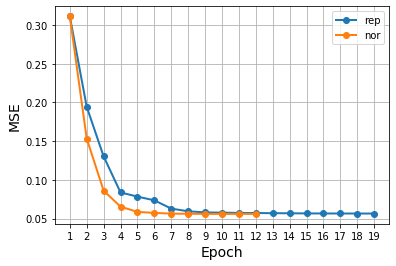

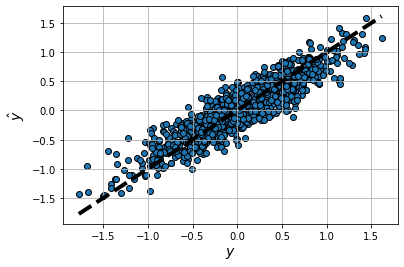

In [10]:
def main(n=1000, d=20, seed=17, noise=1.0, epochs=100, myeps=1e-4):
    """
    Run linear regression with and without replacement for index sampling.
    """
    np.random.seed(seed)
    
    [X, u, y] = gimme_data_regres(n, d, noise)
    mse_list = []
    [wr, mse_r] = linear_regression_cd(X, y, epochs=epochs, eps=myeps, replace=1)
    mse_list.append(mse_r)

    [wn, mse_n] = linear_regression_cd(X, y, eps=myeps, replace=0)
    mse_list.append(mse_n)
    
    return X, y, wn, mse_list


X, y, wn, mse_list = main(seed=17)
loss_plotter(mse_list, 'MSE')
loss_scatter(X, y, wn, 'True vs. Predicted Outcome')